In [69]:
!pip install -r requirements.txt -q


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
test_ds = pd.read_csv('gsm8k_features_test.csv')
#test_ds = test_ds[test_ds.Reason != 'WRONG INTIAL ANSWER']
train_ds = pd.read_csv('gsm8k_features_train.csv')
#train_ds = train_ds[train_ds.Reason != 'WRONG INTIAL ANSWER']

In [62]:
print(train_ds.columns)
print(len(train_ds.columns))
print(len(train_ds))

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Datapoint', 'Prompt_Idx', 'Result',
       'Reason', 'sequence_length', 'num_numerical_tokens', 'num_math_tokens',
       'math_token_ratio', 'has_equals_sign',
       'mean_attention_to_math_tokens_0', 'mean_attention_to_math_tokens_last',
       'mean_attention_from_math_tokens_0',
       'mean_attention_from_math_tokens_last',
       'final_token_attention_received', 'max_attention_from_math_token',
       'self_attention_ratio', 'attention_entropy_layer0_math',
       'head0_max_attention_target_is_math'],
      dtype='object')
20
300


In [55]:
feature_names = ['sequence_length', 'num_numerical_tokens', 'num_math_tokens',
                  'math_token_ratio', 'has_equals_sign',
                  'mean_attention_to_math_tokens_0', 'mean_attention_to_math_tokens_last',
                  'mean_attention_from_math_tokens_0',
                  'mean_attention_from_math_tokens_last',
                  'final_token_attention_received', 'max_attention_from_math_token',
                  'self_attention_ratio', 'attention_entropy_layer0_math',
                  'head0_max_attention_target_is_math']

X_train = train_ds.copy(deep=True)
X_train = X_train[feature_names]
y_train = train_ds.copy(deep=True)
y_train = y_train['Result']
print(list(X_train))

X_test = test_ds.copy(deep=True)
X_test = X_test[feature_names]

y_test = test_ds.copy(deep=True)
y_test = y_test['Result']

['sequence_length', 'num_numerical_tokens', 'num_math_tokens', 'math_token_ratio', 'has_equals_sign', 'mean_attention_to_math_tokens_0', 'mean_attention_to_math_tokens_last', 'mean_attention_from_math_tokens_0', 'mean_attention_from_math_tokens_last', 'final_token_attention_received', 'max_attention_from_math_token', 'self_attention_ratio', 'attention_entropy_layer0_math', 'head0_max_attention_target_is_math']


In [56]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.58      0.20      0.30        35
        True       0.68      0.92      0.78        65

    accuracy                           0.67       100
   macro avg       0.63      0.56      0.54       100
weighted avg       0.65      0.67      0.61       100



In [57]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Decision Tree')
print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest')
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = rf.feature_importances_


Decision Tree
Decision Tree Accuracy: 0.69
              precision    recall  f1-score   support

       False       0.60      0.34      0.44        35
        True       0.71      0.88      0.79        65

    accuracy                           0.69       100
   macro avg       0.66      0.61      0.61       100
weighted avg       0.67      0.69      0.66       100

Random Forest
Random Forest Accuracy: 0.67
              precision    recall  f1-score   support

       False       0.55      0.31      0.40        35
        True       0.70      0.86      0.77        65

    accuracy                           0.67       100
   macro avg       0.62      0.59      0.59       100
weighted avg       0.65      0.67      0.64       100



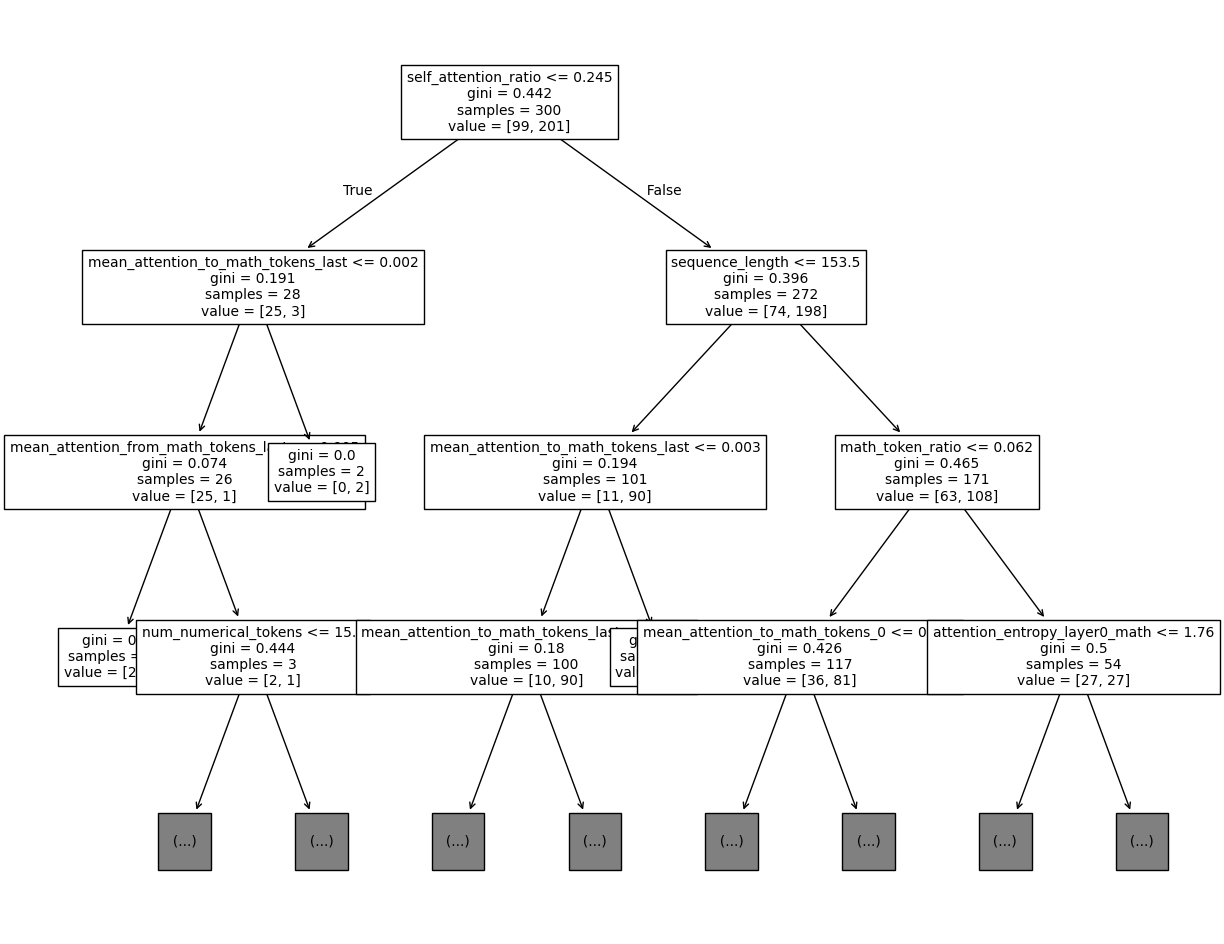

In [64]:
plt.figure(figsize=(15,12))
plot_tree(tree, max_depth=3, feature_names=feature_names, fontsize=10)
plt.savefig('output/decision_tree_3.png')
plt.show()


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np


# 2. Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# 3. Define Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

# 4. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
batch_size = 32

# 5. Training Loop
for epoch in range(epochs):
    permutation = torch.randperm(X_train_t.size()[0])
    epoch_loss = 0
    for i in range(0, X_train_t.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_t[indices], y_train_t[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# 6. Evaluation
with torch.no_grad():
    outputs = model(X_test_t)
    _, preds = torch.max(outputs, 1)

print(classification_report(y_test, preds.numpy()))

Epoch 1/10, Loss: 6.5298
Epoch 2/10, Loss: 6.0703
Epoch 3/10, Loss: 5.8303
Epoch 4/10, Loss: 5.5313
Epoch 5/10, Loss: 5.5133
Epoch 6/10, Loss: 5.4339
Epoch 7/10, Loss: 5.5409
Epoch 8/10, Loss: 5.5563
Epoch 9/10, Loss: 5.2993
Epoch 10/10, Loss: 5.3242
              precision    recall  f1-score   support

       False       0.70      0.20      0.31        35
        True       0.69      0.95      0.80        65

    accuracy                           0.69       100
   macro avg       0.69      0.58      0.56       100
weighted avg       0.69      0.69      0.63       100



14


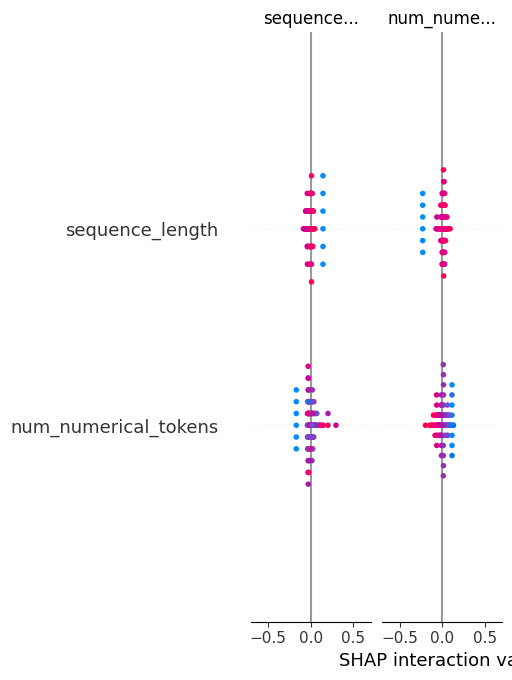

In [81]:
import shap

print(input_dim)
# Assume `model` is trained, `X_train` and `X_test` are numpy arrays
# Convert model to eval mode
model.eval()

# Use a small background sample for efficiency
background = X_train_t[:].clone().detach().float()
test_samples = X_test_t[:].clone().detach().float()

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_samples)

# Visualize feature importance
shap.summary_plot(shap_values, X_test[:], feature_names=feature_names)

In [83]:
print(len(X_train_t))
print(X_train_t.shape)

300
torch.Size([300, 14])


In [108]:
class_idx = 1
shap_values_class1 = shap_values[:, :, class_idx]

feature_names = ['sequence_length', 'num_numerical_tokens', 'num_math_tokens',
                  'math_token_ratio', 'has_equals_sign',
                  'mean_attention_to_math_tokens_0', 'mean_attention_to_math_tokens_last',
                  'mean_attention_from_math_tokens_0',
                  'mean_attention_from_math_tokens_last',
                  'final_token_attention_received', 'max_attention_from_math_token',
                  'self_attention_ratio', 'attention_entropy_layer0_math',
                  'head0_max_attention_target_is_math']
# Plot SHAP summary for all features
plt.clf()
shap.summary_plot(shap_values_class1, X_test, feature_names=feature_names, show=False)
plt.savefig(f"output/shap_summary_{class_idx}.png",dpi=700, bbox_inches="tight") #.png,.pdf will also support here
plt.close()